# Graph analysis

## Basics

First, a simple example. Create a graph of synonyms using WordNet.

In [42]:
%matplotlib inline
import re
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import wordnet as wn


def graph_synsets(terms, pos=wn.NOUN, depth=2):
    """
    Create a networkx graph of the given terms to the given depth.
    """

    G = nx.Graph(
        name="WordNet Synsets Graph for {}".format(", ".join(terms)), depth=depth,
    )

    def add_term_links(G, term, current_depth):
        for syn in wn.synsets(term):
            for name in syn.lemma_names():
                G.add_edge(term, name)
                if current_depth < depth:
                    add_term_links(G, name, current_depth+1)

    for term in terms:
        add_term_links(G, term, 0)

    return G


def draw_text_graph(G):
    plt.figure(figsize=(18,12))
    pos = nx.spring_layout(G, scale=18)
    nx.draw_networkx_nodes(G, pos, node_color="white", linewidths=0, node_size=500)
    nx.draw_networkx_labels(G, pos, font_size=10)
    nx.draw_networkx_edges(G, pos)
    plt.xticks([])
    plt.yticks([])

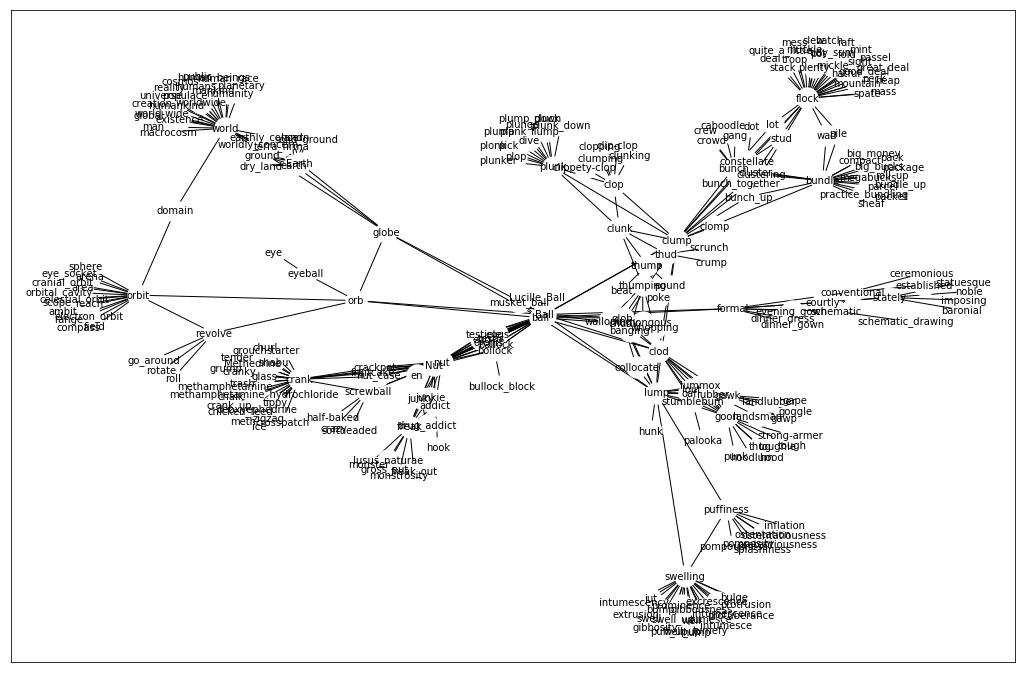

In [22]:
g = graph_synsets(['ball'])
draw_text_graph(g)

In [49]:
print(nx.info(g))

Name: WordNet Synsets Graph for ball
Type: Graph
Number of nodes: 267
Number of edges: 506
Average degree:   3.7903


## Network measures

### Diameter

The longest shortest path between any two nodes in the graph. In other words, how many hops apart are the most distant nodes?

### Degree

For any node, with how many other nodes does it share an edge?

### Clique

One or more nodes that, as a group, are not connected to at least one node in the full graph.

### Transitivity

Ratio of triangular connections to total connected triples. A measure of "socialness."

### Clustering coefficient

A number between 0 and 1 that measures "cliquiness." 0 = absence of cliques; 1 = nothing but cliques.

### Degree centrality

For each node, its degree divided by the total number of nodes in the graph. A measure of importance in terms of number of connections.

### Closeness centrality

For each node, the average shortest number of hops to each other node in the graph, divided by the size of the graph. A measure of node importance for information flow.

### Betweenness centrality

For each node, the number of shortest paths between all other nodes that run through the node in question. A measure of how much that node contributes to the connectedness of the graph as a whole.

### Eigenvector centrality

For each node, what is the degree of each of the nodes to which it is connected. Used in Katz and Pagerank measures.

### Katz centrality

A more complicated version of eigenvector centrality that includes nodes beyond immediate neighbors. Distant nodes are downweightd in proportion to their distance.

### Pagerank centrality

Another eigenvector-based method, used by Google to rank web page importance. Similar to Katz centrality, but uses the probability of reaching a node from any random starting node on the basis of the distribution of links between all nodes in the graph. Think of each node has having a number of "votes" equal to the number of incoming links to it, which it then distributes equally to all nodes to which it is connected.

## Entities

In [31]:
import spacy
import heapq
import itertools
import networkx as nx
import os
import sys
import time

from operator import itemgetter

# Import our libraries
sys.path.append(os.path.join('..', 'libraries'))
from TMN import TMNCorpusReader, PickledCorpusReader

nlp = spacy.load('en')

#GOOD_ENTS = ['PERSON', 'NORP', 'FACILITY', 'ORG', 'GPE', 'LOC',
#             'PRODUCT', 'EVENT', 'WORK_OF_ART', 'LANGUAGE']
GOOD_ENTS = ['GPE', 'LOC']

def entities(sent):
    doc = nlp(sent)
    for ent in doc.ents:
        #  filter out non-target entities
        if ent.label_ in GOOD_ENTS:
            return ent.text, ent.label_
        else:
            pass

def pairs(doc):
    candidates = [
        entities(' '.join(word for word, tag in sent))
        for para in doc for sent in para
    ]

    doc_entities = [
        entity for entity in candidates if entity is not None
    ]

    return list(itertools.permutations(set(doc_entities), 2))


def graph(docs):
    G = nx.Graph()
    for doc in docs:
        print(time.ctime())
        for pair in pairs(doc):
            if (pair[0][0], pair[1][0]) in G.edges():
                G.edges[(pair[0][0], pair[1][0])]['weight'] += 1
            else:
                G.add_edge(pair[0][0], pair[1][0], weight=1)
    return G

def nbest_centrality(G, metric, n=10, attr="centrality", **kwargs):
    # Compute the centrality scores for each vertex
    scores = metric(G, **kwargs)

    # Set the score as a property on each node
    nx.set_node_attributes(G, name=attr, values=scores)

    # Find the top n scores and print them along with their index
    topn = heapq.nlargest(n, scores.items(), key=itemgetter(1))
    for idx, item in enumerate(topn):
        print("{}. {}: {:0.4f}".format(idx + 1, *item))

    return G

In [32]:
%%time
# Where are the corpus texts on your system
pickle_dir = os.path.join('..', 'data', 'pickled')
# Set up corpus
corpus = PickledCorpusReader(pickle_dir)

# Create entity pair graph
docs = corpus.docs()
G = graph(docs)

Tue Apr  9 22:14:21 2019
Tue Apr  9 22:16:05 2019
Tue Apr  9 22:16:56 2019
Tue Apr  9 22:18:00 2019
Tue Apr  9 22:18:42 2019
Tue Apr  9 22:19:00 2019
Tue Apr  9 22:19:11 2019
Tue Apr  9 22:21:08 2019
Tue Apr  9 22:22:02 2019
Tue Apr  9 22:22:38 2019
Tue Apr  9 22:23:21 2019
Tue Apr  9 22:23:58 2019
Tue Apr  9 22:25:14 2019
Tue Apr  9 22:26:53 2019
Tue Apr  9 22:27:13 2019
Tue Apr  9 22:27:29 2019
Tue Apr  9 22:29:14 2019
Tue Apr  9 22:30:35 2019
Tue Apr  9 22:32:12 2019
Tue Apr  9 22:33:15 2019
Tue Apr  9 22:34:07 2019
Tue Apr  9 22:35:09 2019
Tue Apr  9 22:36:49 2019
Tue Apr  9 22:37:55 2019
Tue Apr  9 22:39:10 2019
Tue Apr  9 22:39:34 2019
Tue Apr  9 22:42:55 2019
Tue Apr  9 22:44:19 2019
Tue Apr  9 22:46:56 2019
Tue Apr  9 22:47:51 2019
Tue Apr  9 22:49:37 2019
Tue Apr  9 22:51:38 2019
Tue Apr  9 22:52:57 2019
Tue Apr  9 22:53:15 2019
Tue Apr  9 22:55:21 2019
Tue Apr  9 22:55:55 2019
Tue Apr  9 22:56:33 2019
Tue Apr  9 22:59:00 2019
Tue Apr  9 23:02:30 2019
Tue Apr  9 23:02:48 2019


In [33]:
# Write the graph to disk, if needed
graph_dir = os.path.join('..', 'data', 'graphs')
nx.write_graphml(G, os.path.join(graph_dir, "entities.graphml"))

In [39]:
%%time
# Get summary stats for the full graph
print(nx.info(G))

# find the most central entities in the social network
print("\nDegree centrality")
nbest_centrality(G, nx.degree_centrality)
print("\nBetweenness centrality")
nbest_centrality(G, nx.betweenness_centrality, 10, "betweenness", normalized=True)

Name: 
Type: Graph
Number of nodes: 2336
Number of edges: 272687
Average degree: 233.4649

Degree centrality
1. London: 0.8904
2. England: 0.8253
3. France: 0.8133
4. Europe: 0.8081
5. earth: 0.8051
6. Providence: 0.7850
7. Paris: 0.7743
8. America: 0.7653
9. Rome: 0.7041
10. XI: 0.6985

Betweenness centrality
1. London: 0.0478
2. earth: 0.0451
3. England: 0.0342
4. Providence: 0.0333
5. Europe: 0.0324
6. France: 0.0292
7. XI: 0.0271
8. America: 0.0234
9. Paris: 0.0232
10. Rome: 0.0230
CPU times: user 3min 51s, sys: 1.12 s, total: 3min 52s
Wall time: 3min 54s


/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


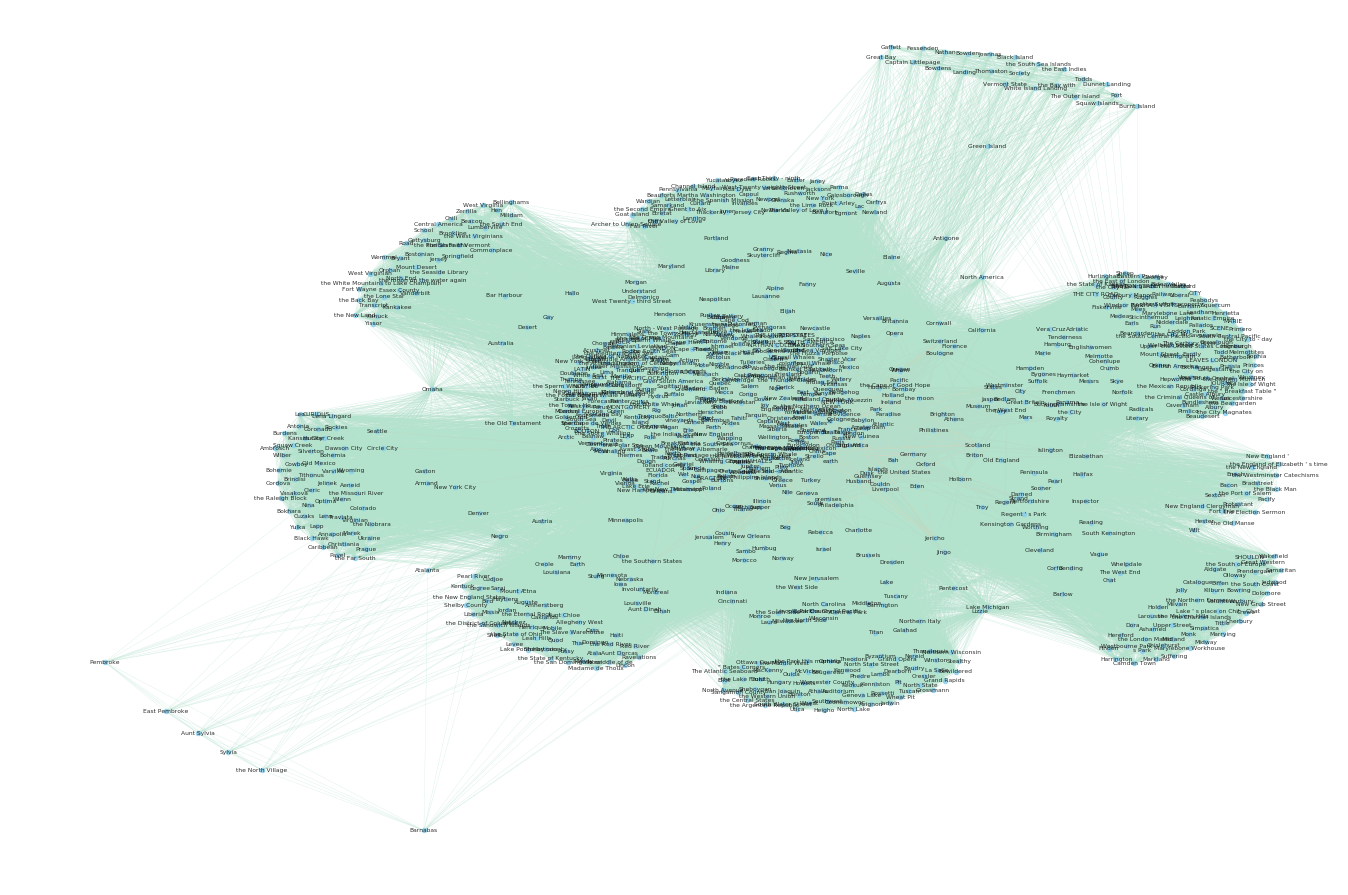

Closeness centrality for Boston
1. Boston: 1.0000
2. America: 0.9526
3. New York: 0.9490
4. England: 0.9211
5. earth: 0.9119
6. London: 0.9094
7. Paris: 0.9053
8. Providence: 0.8815
9. India: 0.8753
10. France: 0.8670

Eigenvector centrality for Boston
1. Boston: 0.0640
2. America: 0.0636
3. New York: 0.0635
4. England: 0.0630
5. Paris: 0.0628
6. India: 0.0623
7. earth: 0.0623
8. London: 0.0622
9. Europe: 0.0621
10. France: 0.0619

Pagerank centrality for Boston
1. London: 0.0059
2. earth: 0.0057
3. England: 0.0056
4. America: 0.0054
5. Paris: 0.0052
6. France: 0.0052
7. Providence: 0.0051
8. Europe: 0.0050
9. New York: 0.0047
10. XI: 0.0047

Katz centrality for Boston
1. earth: 0.1710
2. Pembroke: 0.1594
3. East Pembroke: 0.1594
4. the North Village: 0.1594
5. Sylvia: 0.1594
6. Barnabas: 0.1594
7. Aunt Sylvia: 0.1594
8. Boston: 0.1548
9. Hallo: 0.1534
10. New England: 0.1522
Full graph degrees


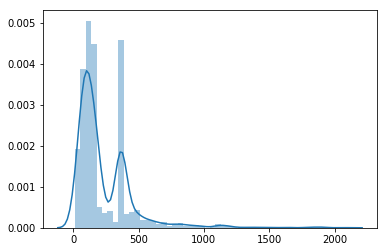

Boston ego graph degrees


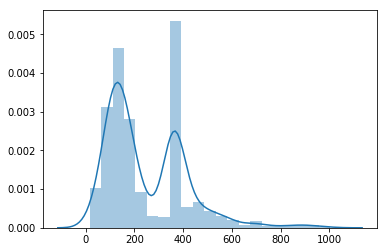

New York ego graph degrees


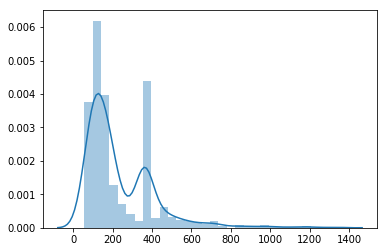

London ego graph degrees


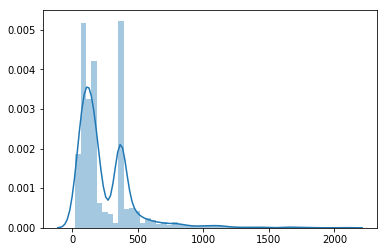


Corpus Entity Graph
Transitivity: 0.5591575739291381
Average clustering coefficient: 0.9096324618421322
Number of cliques: 1132807

Boston Ego Graph
Transitivity: 0.7264431582287397
Average clustering coefficient: 0.8895642359107322
Number of cliques: 771686
CPU times: user 5min 5s, sys: 4.04 s, total: 5min 9s
Wall time: 5min 16s


In [51]:
%%time
fig_dir = os.path.join('..', 'data', 'images')

# Extract and visualize an ego graph
H = nx.ego_graph(G, "Boston")
edges, weights = zip(*nx.get_edge_attributes(H, "weight").items())
pos = nx.spring_layout(H, k=0.3, iterations=40)
plt.figure(figsize=(18,12))
nx.draw(
    H, pos, node_color="skyblue", node_size=20, edgelist=edges,
    edge_color=weights, width=0.25, edge_cmap=plt.cm.Pastel2,
    with_labels=True, font_size=6, alpha=0.8)
plt.savefig(os.path.join(fig_dir, "ch09_boston_entity_graph.png"), transparent=True)
plt.show()

# Compare centrality measures for an ego graph
print("Closeness centrality for Boston")
nbest_centrality(H, nx.closeness_centrality, 10, "closeness")
print("\nEigenvector centrality for Boston")
nbest_centrality(H, nx.eigenvector_centrality_numpy, 10, "eigenvector")
print("\nPagerank centrality for Boston")
nbest_centrality(H, nx.pagerank_numpy, 10, "pagerank")
print("\nKatz centrality for Boston")
nbest_centrality(H, nx.katz_centrality_numpy, 10, "katz")

T = nx.ego_graph(G, "New York")
E = nx.ego_graph(G, "London")

# Examine degree distributions with histograms
print("\nFull graph degrees")
sns.distplot(
    [G.degree(v) for v in G.nodes()], norm_hist=True
)
plt.show()

print("Boston ego graph degrees")
sns.distplot(
    [H.degree(v) for v in H.nodes()], norm_hist=True
)
plt.show()

print("New York ego graph degrees")
sns.distplot(
    [T.degree(v) for v in T.nodes()], norm_hist=True
)
plt.show()

print("London ego graph degrees")
sns.distplot(
    [E.degree(v) for v in E.nodes()], norm_hist=True
)
plt.show()

print("\nCorpus Entity Graph")
print("Transitivity: {}".format(nx.transitivity(G)))
print("Average clustering coefficient: {}".format(nx.average_clustering(G)))
print("Number of cliques: {}".format(nx.graph_number_of_cliques(G)))

print("\nBoston Ego Graph")
print("Transitivity: {}".format(nx.transitivity(H)))
print("Average clustering coefficient: {}".format(nx.average_clustering(H)))
print("Number of cliques: {}".format(nx.graph_number_of_cliques(H)))